### 概要

ETL8BじゃなくてETL9Bに変更する


転移学習で文字認識させる例として、MobileNetV3・MNISTをやる。

  * [Image Classification of MNIST using VGG16 \| Kaggle](https://www.kaggle.com/code/viratkothari/image-classification-of-mnist-using-vgg16/notebook)
    * グレイスケールからRGBへの変換に `np.dstack` を使用しているが、横に3重になってしまっている
      * `dstack` じゃなく `stack(..., axis=-1)` と変更する
    * `plot_value_array` で違う内容を表示してしまっている
    * 追加する `Dense` レイヤーを全て `flattten` からにしてしまっているので、層が重なってない
    * バリデーション用のデータがテストと同じものを使用している

[Transfer learning & fine-tuning](https://keras.io/guides/transfer_learning/) も見て見たらいいかも


### TensorFlowインポート

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV3Small

import numpy as np
import matplotlib.pyplot as plt
import random

### GoogleDriveに置いているデータを持ってくる

  * Zipファイルを展開

In [4]:
from google.colab import drive
drive.mount('./drive')

!cp drive/MyDrive/etl9b64.zip ./
!rm -rf data
!unzip -qo etl9b64.zip

Drive already mounted at ./drive; to attempt to forcibly remount, call drive.mount("./drive", force_remount=True).


### 画像ファイル読み込み

学習データ・バリデーションデータ・テストデータに分割

In [5]:
def load_list_file(fn):
    with open(fn, 'r', encoding='UTF-8') as f:
        ls = f.read().splitlines()
    random.shuffle(ls)
    return ls

train_files = load_list_file('data/train.txt')
valid_files = load_list_file('data/valid.txt')
test_files = load_list_file('data/test.txt')

### データ確認

水増し実行

256 (64, 64, 1)


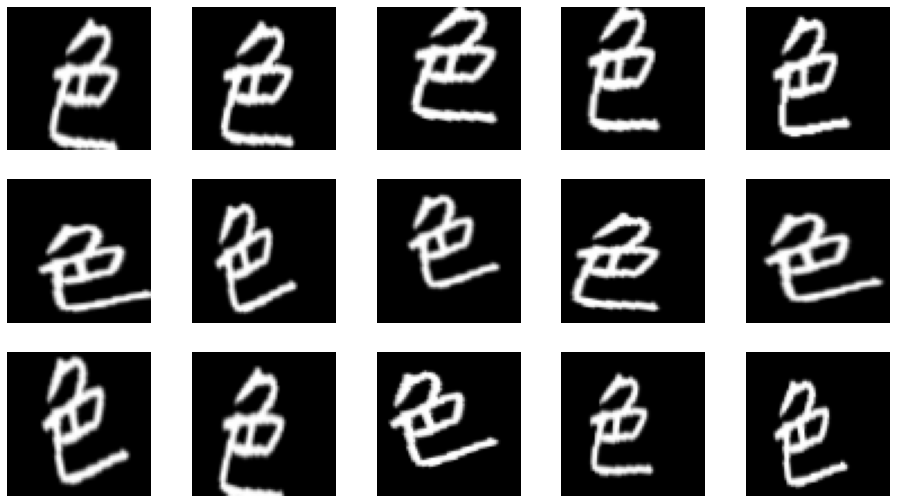

In [6]:
def test_augmentation():
    global IMG_SHAPE
    global BATCH_SIZE

    data = np.load(train_files[0])
    image = random.choice(data['x'])

    BATCH_SIZE = data['x'].shape[0]
    IMG_SHAPE = image.shape
    print(BATCH_SIZE, IMG_SHAPE)
    assert IMG_SHAPE[2] == 1

    input = layers.Input(shape=IMG_SHAPE)
    gray2rgb_layer = layers.Concatenate()([input] * 3)
    gray2rgb = keras.models.Model(inputs=input, outputs=gray2rgb_layer, name='gray2rgb')

    data_augmentation = tf.keras.Sequential([
        layers.Rescaling(1.0 / 255),
        layers.RandomRotation(0.05, fill_mode='constant'),
        layers.RandomZoom(height_factor=(-0.1, 0.5), width_factor=(-0.1, 0.5), fill_mode='constant'),
        layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), fill_mode='constant'),
    ], name='augmentation')

    plt.figure(figsize=(16, 9))
    for i in range(3 * 5):
        augmented_image = data_augmentation(tf.expand_dims(image, 0))
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(gray2rgb(augmented_image)[0])
        plt.axis("off")
test_augmentation()

### 転移元モデル読み込み

`include_top=False` で最終レイヤーを無効にする。

In [11]:
pretrained_model = MobileNetV3Small(
    input_tensor=layers.Input(shape=IMG_SHAPE[:-1] + (3,)),
    weights='imagenet',
    include_top=False)

pretrained_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 rescaling_4 (Rescaling)        (None, 64, 64, 3)    0           ['input_4[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 32, 32, 16)   432         ['rescaling_4[0][0]']            
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 32, 32, 16)  64          ['Conv[0][0]']                   
 tion)                                                                             

### モデルの構築

  * グレースケール入力をRGB同じ値のカラー画像に変換する
  * 学習済みモデルをいったん絞って重みの数を削減する

この辺りで素で実行して `data_augmentation` の確認をすると画像に変更が入らないので、実際の訓練時に水増しできているのか確認できてない…。

In [12]:
NCLASS = 3036

def create_model():
    input = layers.Input(shape=IMG_SHAPE)
    gray2rgb_layer = layers.Concatenate()([input] * 3)

    data_augmentation = tf.keras.Sequential([
        layers.Rescaling(1.0 / 255),
        layers.RandomRotation(0.05, fill_mode='constant'),
        layers.RandomZoom(height_factor=(-0.1, 0.5), width_factor=(-0.1, 0.5), fill_mode='constant'),
        layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), fill_mode='constant'),
        layers.Rescaling(255),
    ], name='augmentation')

    model = keras.Sequential([
        keras.models.Model(inputs=input, outputs=gray2rgb_layer, name='gray2rgb'),
        data_augmentation,
        pretrained_model,
        layers.GlobalAveragePooling2D(),
        # layers.Flatten(),
        # layers.Dropout(0.2),
        # layers.Dense(512, activation='relu'),
        # layers.Dropout(0.2),
        layers.BatchNormalization(),  # Dropoutの代わりにこちらを使う？
        layers.Dense(NCLASS, activation='softmax'),
    ])
    return model

model = create_model()

# Summarize the model
model.summary()

# Compiling Model

# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adamax',metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gray2rgb (Functional)       (None, 64, 64, 3)         0         
                                                                 
 augmentation (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 MobilenetV3small (Functiona  (None, 2, 2, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization (BatchN  (None, 576)              2304      
 ormalization)                                                   
                                                      

### ジェネレータ

In [13]:
# Generator

class NpzGen(keras.utils.Sequence):
    # files: .npzファイル名
    def __init__(self, files):
        self.files = files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = np.load(self.files[idx])
        return data['x'], data['y']

### 学習

In [14]:
EPOCHS = 100
# BATCH_SIZE = 128

traingen = NpzGen(train_files)
validgen = NpzGen(valid_files)

# # Fit the Model
history = model.fit(traingen, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=True, validation_data=validgen)

print("Fitting the model completed.")

Epoch 1/100
1976/1976 [==============================] - 116s 56ms/step - loss: 3.2115 - accuracy: 0.4963 - val_loss: 1.8060 - val_accuracy: 0.5662
Epoch 2/100
1976/1976 [==============================] - 111s 56ms/step - loss: 0.3585 - accuracy: 0.9154 - val_loss: 0.3196 - val_accuracy: 0.9163
Epoch 3/100
1976/1976 [==============================] - 109s 55ms/step - loss: 0.1912 - accuracy: 0.9496 - val_loss: 0.2069 - val_accuracy: 0.9425
Epoch 4/100
1976/1976 [==============================] - 110s 55ms/step - loss: 0.1369 - accuracy: 0.9626 - val_loss: 0.1766 - val_accuracy: 0.9490
Epoch 5/100
1976/1976 [==============================] - 111s 56ms/step - loss: 0.1083 - accuracy: 0.9699 - val_loss: 0.1000 - val_accuracy: 0.9723
Epoch 6/100
1976/1976 [==============================] - 108s 55ms/step - loss: 0.0907 - accuracy: 0.9744 - val_loss: 0.1204 - val_accuracy: 0.9655
Epoch 7/100
1976/1976 [==============================] - 108s 55ms/step - loss: 0.0779 - accuracy: 0.9778 - val_

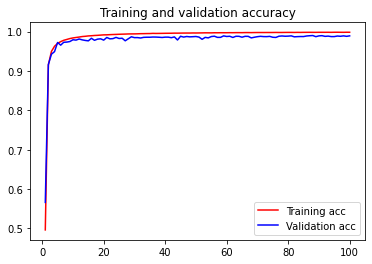

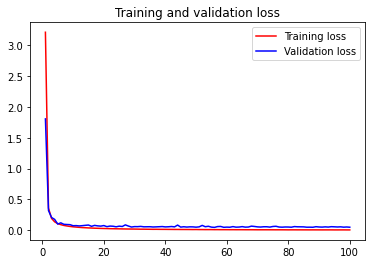

In [15]:
# plot the loss and accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()
plt.show()

In [16]:
testgen = NpzGen(test_files)

predictions = model.predict(testgen)

ytest = None
for i in range(len(test_files)):
    data = np.load(test_files[i])
    ans = data['y']
    ytest = ans if ytest is None else np.concatenate([ytest, ans])

results = np.argmax(predictions, axis=1) == ytest
print('Test Accuracy:', results.sum() / results.shape[0])

Test Accuracy: 0.9890229430379747


In [17]:
model.save('./trained.h5')

Classification of using Transfer Learning

Predicted, Percentage, (Original)



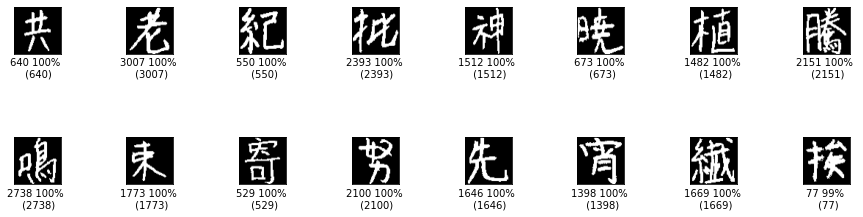

In [18]:
print("Classification of using Transfer Learning\n")
print("Predicted, Percentage, (Original)\n")

# This function plots the image supplied in array
def plot_image(x, y, model):
    def gray2rgb(tensor):
        return np.dstack([tensor] * 3)

    predictions_array = model.predict(x.reshape(1, *IMG_SHAPE))
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(gray2rgb(x))
    
    predicted_label = np.argmax(predictions_array)

    if predicted_label == y: #setting up label color
        color='green' # correct then blue colour
    else:
        color='red' # wrong then red colour
    
    plt.xlabel("{} {:2.0f}% \n ({})".format(str(predicted_label), 
                                            100 * np.max(predictions_array), str(y), 
                                            color=color, horizontalalignment='left'))

def predict_test_image():
    # Declaring variables
    num_rows = 2
    num_cols = 8
    num_images = num_rows * num_cols

    plt.figure(figsize=(2 * num_cols, 2 * num_rows))

    batch_file = random.choice(test_files)
    data = np.load(batch_file)

    order = list(range(BATCH_SIZE))
    random.shuffle(order)

    for i in range(num_images):
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
        plot_image(data['x'][order[i]], data['y'][order[i]], model)
    plt.subplots_adjust(hspace=0.5)
    plt.show()

predict_test_image()

In [19]:
!pip install tensorflowjs
!rm -rf tfjsmodel
!tensorflowjs_converter --input_format=keras --output_format=tfjs_graph_model ./trained.h5 ./tfjsmodel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 416 kB/s 
     |████████████████████████████████| 40 kB 6.6 MB/s 
     |████████████████████████████████| 462 kB 8.3 MB/s 
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


2022-05-26 08:30:19.191609: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-05-26 08:30:27.920019: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Writing weight file ./tfjsmodel/model.json...


In [20]:
!rm -rf tfjsmodel.zip
!zip -r tfjsmodel tfjsmodel/*

from google.colab import files
files.download('./tfjsmodel.zip')

  adding: tfjsmodel/group1-shard1of3.bin (deflated 7%)
  adding: tfjsmodel/group1-shard2of3.bin (deflated 8%)
  adding: tfjsmodel/group1-shard3of3.bin (deflated 7%)
  adding: tfjsmodel/model.json (deflated 96%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>